In [8]:
# # !pip install opencv-python
# !pip install ultralytics opencv-python pillow

In [ ]:
# Install required packages
# pip install ultralytics opencv-python pillow

import cv2
import numpy as np
import os
from ultralytics import YOLO

# ----------------------------
# 1. Download YOLO weights if missing
# ----------------------------
def download_weights(weights_name="yolov8n.pt"):
    """
    Download YOLO pretrained weights from Ultralytics if not available locally.
    Options: yolov8n.pt, yolov8s.pt, yolov8m.pt, yolov8l.pt, yolov8x.pt
    """
    if not os.path.exists(weights_name):
    # if 1==1:
        import requests
        url = f"https://github.com/ultralytics/assets/releases/download/v0.0.0/{weights_name}"
        #url = "https://github.com/therajsekharsaha/pestdetection/tree/main/pestdetection/yolov8n.pt"
        print(f"Downloading {weights_name}...")
        r = requests.get(url)
        with open('Model/'+weights_name, "wb") as f:
            f.write(r.content)
        print(f"✅ Downloaded {weights_name}")
    else:
        print(f"⚡ Using cached weights: {weights_name}")

# Call function to ensure weights are present
download_weights("yolov8s.pt")



⚡ Using cached weights: yolov8s.pt


In [ ]:

# ----------------------------
# 2. Load image & preprocessing
# ----------------------------
from PIL import Image
image_path = "/Users/sajin/ML/Projects/Agri-1/Fly/Images/"  # replace with your trap image
processed_path = "/Users/sajin/ML/Projects/Agri-1/Fly/Images/processed/"
images_list = os.listdir(image_path)
images_list = [x for x in images_list if x.find('det') ==-1 & x.find('preprocessed_') == -1 & x.find('processed') == -1 ]
print(images_list)


for each_image in images_list:
    img = cv2.imread(image_path+ each_image)
    print(f"processing image {each_image}")

    # Resize for consistency
    print(f"Reshaping {each_image} from {img.shape} to (1280, 720)")
    img = cv2.resize(img, (1280, 720))

    # Convert BGR → HSV to normalize yellow background
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Mask yellow background
    lower_yellow = np.array([20, 80, 80])
    upper_yellow = np.array([40, 255, 255])
    mask = cv2.inRange(hsv, lower_yellow, upper_yellow)

    # Invert mask → insects remain
    mask_inv = cv2.bitwise_not(mask)
    refined = cv2.bitwise_and(img, img, mask=mask_inv)

    # Contrast enhancement with CLAHE
    gray = cv2.cvtColor(refined, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    gray_eq = clahe.apply(gray)
    refined = cv2.cvtColor(gray_eq, cv2.COLOR_GRAY2BGR)

    file = processed_path+"preprocessed_"+each_image
    print(file)
    if not os.path.exists(file):
       cv2.imwrite(file, refined)


    # ----------------------------
    # 3. Load YOLOv8 Model
    # ----------------------------
    yolo_model = YOLO("Model/best.pt")  # lightweight model for testing
   #  yolo_model = YOLO("yolov8s.pt")  # lightweight model for testing
    # You can swap for yolov8s.pt or yolov8m.pt for more accuracy

    # ----------------------------
    # 4. Run Detection
    # ----------------------------
   #  results = model.predict(refined, imgsz=640, conf=0.25)
    results = yolo_model.predict(img, conf=0.30 )
    # ----------------------------
    # 5. Draw bounding boxes & labels
    # ----------------------------
    #print('R :',results[0].boxes)
    boxes = results[0].boxes
    xyxy = boxes.xyxy
    xywh = boxes.xywh
    conf = boxes.conf
    cls  = boxes.cls

    bboxes = []
    for xyxy_box in boxes.xyxy.cpu().numpy():
       x1, y1, x2, y2 = xyxy_box
       w, h = x2 - x1, y2 - y1
       bboxes.append((int(x1), int(y1), int(w), int(h)))

    print(bboxes)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    pil_img = Image.fromarray(img_rgb) 

    preds = classify_bboxes_with_clip(pil_img, bboxes)
    annotated = img.copy()
    for p in preds:
      print('CLIP: ',p)
      x, y, w, h = p["bbox"]
      label = f"{p['label']} ({p['confidence']:.2f})"
      cv2.rectangle(annotated, (x, y), (x+w, y+h), (0, 255, 0), 2)
      (tw, th), baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
      cv2.rectangle(annotated, (x, y-th-4), (x+tw, y), (0, 255, 0), -1)
      cv2.putText(annotated, label, (x, y-2), cv2.FONT_HERSHEY_SIMPLEX,0.5, (0, 0, 0), 1, cv2.LINE_AA)

    #annotated = results[0].plot(img = img.copy())  # built-in visualization

    # Save output
    cv2.imwrite(image_path + "det_"+ each_image, annotated)

    print(f"✅ Detection complete! Results saved det_{each_image}")


['IMG-20250817-WA0081.jpg', 'IMG-20250817-WA0082.jpg', 'IMG-20250817-WA0083.jpg', 'IMG-20250817-WA0084.jpg', 'IMG-20250817-WA0085.jpg']
processing image IMG-20250817-WA0081.jpg
Reshaping IMG-20250817-WA0081.jpg from (1600, 900, 3) to (1280, 720)
/Users/sajin/ML/Projects/Agri-1/Fly/Images/processed/preprocessed_IMG-20250817-WA0081.jpg

0: 384x672 8 fruit flys, 57.5ms
Speed: 35.8ms preprocess, 57.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 672)
[(702, 313, 126, 38), (333, 253, 66, 44), (915, 645, 108, 37), (370, 329, 78, 39), (43, 621, 110, 53), (551, 543, 208, 75), (956, 648, 80, 34), (386, 329, 75, 39)]
CLIP:  {'bbox': (702, 313, 126, 38), 'label': 'fungus gnat', 'confidence': 0.7956477403640747, 'topk': [('fungus gnat', 0.7956477403640747)]}
CLIP:  {'bbox': (333, 253, 66, 44), 'label': 'fungus gnat', 'confidence': 0.5973458886146545, 'topk': [('fungus gnat', 0.5973458886146545)]}
CLIP:  {'bbox': (915, 645, 108, 37), 'label': 'fungus gnat', 'confidence': 0.574971854

In [6]:
# pip install git+https://github.com/openai/CLIP.git pillow torchvision

In [5]:
import torch
import clip                # from OpenAI/CLIP repo
from PIL import Image
from torchvision import transforms
import numpy as np
from typing import List, Tuple, Dict

# --- CONFIG ---
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_NAME = "RN50"   # clip models: "ViT-B/32", "RN50", etc.
CLASS_NAMES = [
    "aphid",
    "whitefly",
    "thrips",
    "spider mite",
    "fungus gnat",
    "leafhopper",
    "beetle"
]
TOP_K = 1                 # return top-k labels (set >1 if you want multiple)
CONFIDENCE_THRESHOLD = 0.35  # below this -> "unknown" (tune for your data)

# --- Load CLIP model & preprocessing ---
model, preprocess = clip.load(MODEL_NAME, device=DEVICE)
model.eval()

# Create text prompts for each class (can be tuned)
def build_prompts(class_names: List[str]) -> List[str]:
    # small prompt engineering: be explicit it's an insect/pest
    prompts = []
    for c in class_names:
        prompts.append(f"a close up photo of a {c}")
        prompts.append(f"a small insect identified as {c}")
    return prompts

TEXT_PROMPTS = build_prompts(CLASS_NAMES)

# Pre-encode text embeddings (we average prompt variants per class)
with torch.no_grad():
    text_tokens = clip.tokenize(TEXT_PROMPTS).to(DEVICE)
    text_embeddings = model.encode_text(text_tokens)  # (N_prompts, D)
    # normalize
    text_embeddings = text_embeddings / text_embeddings.norm(dim=-1, keepdim=True)

# Group embeddings per class by averaging variants
def class_embeddings_from_prompt_embeddings(class_names: List[str],
                                            text_embeddings: torch.Tensor) -> torch.Tensor:
    # our build_prompts made 2 prompts per class in same order
    per_class = []
    prompts_per_class = len(TEXT_PROMPTS) // len(class_names)
    for i in range(len(class_names)):
        start = i * prompts_per_class
        end = start + prompts_per_class
        emb = text_embeddings[start:end].mean(dim=0)
        emb = emb / emb.norm()  # re-normalize
        per_class.append(emb)
    return torch.stack(per_class, dim=0)  # (num_classes, D)

CLASS_EMBEDDINGS = class_embeddings_from_prompt_embeddings(CLASS_NAMES, text_embeddings)

# --- Helper: crop boxes and run CLIP ---
def crop_from_bbox(pil_img: Image.Image, bbox: Tuple[int,int,int,int]) -> Image.Image:
    """
    bbox expected as (x, y, w, h) in pixel coordinates.
    Ensures bbox inside image, returns PIL crop.
    """
    x, y, w, h = bbox
    # convert to left, upper, right, lower
    left = max(int(x), 0)
    upper = max(int(y), 0)
    right = min(int(x + w), pil_img.width)
    lower = min(int(y + h), pil_img.height)
    if right <= left or lower <= upper:
        # fallback: return full image if bbox degenerate
        return pil_img.copy()
    return pil_img.crop((left, upper, right, lower))

def classify_bboxes_with_clip(
    pil_img: Image.Image,
    bboxes: List[Tuple[int,int,int,int]],
    top_k: int = TOP_K,
    threshold: float = CONFIDENCE_THRESHOLD
) -> List[Dict]:
    """
    Args:
      pil_img: PIL.Image of full image
      bboxes: list of (x, y, w, h)
    Returns:
      list of dicts: {bbox, label, confidence, topk: [(label, score), ...]}
    """
    crops = [crop_from_bbox(pil_img, bbox) for bbox in bboxes]
    # Preprocess crops to CLIP input
    inputs = torch.stack([preprocess(crop) for crop in crops], dim=0).to(DEVICE)  # (N, 3, H, W)
    with torch.no_grad():
        image_embeddings = model.encode_image(inputs)  # (N, D)
        image_embeddings = image_embeddings / image_embeddings.norm(dim=-1, keepdim=True)

        # similarity: cosine between image and class embeddings
        # CLASS_EMBEDDINGS: (C, D)
        # image_embeddings: (N, D)
        sims = (image_embeddings @ CLASS_EMBEDDINGS.T)  # (N, C)
        # Optionally scale by temperature if you want softmax; CLIP's default logit_scale:
        logit_scale = model.logit_scale.exp().detach() if hasattr(model, "logit_scale") else 1.0
        sims = sims * logit_scale

        # Turn to probabilities with softmax for interpretability
        probs = sims.softmax(dim=-1)  # (N, C)

        results = []
        for i in range(sims.shape[0]):
            prob_row = probs[i].cpu().numpy()
            # topk indices
            topk_idx = np.argsort(prob_row)[::-1][:top_k]
            topk = [(CLASS_NAMES[idx], float(prob_row[idx])) for idx in topk_idx]
            # pick best
            best_idx = int(topk_idx[0])
            best_score = float(prob_row[best_idx])
            label = CLASS_NAMES[best_idx] if best_score >= threshold else "unknown"
            results.append({
                "bbox": bboxes[i],
                "label": label,
                "confidence": best_score,
                "topk": topk
            })
    return results



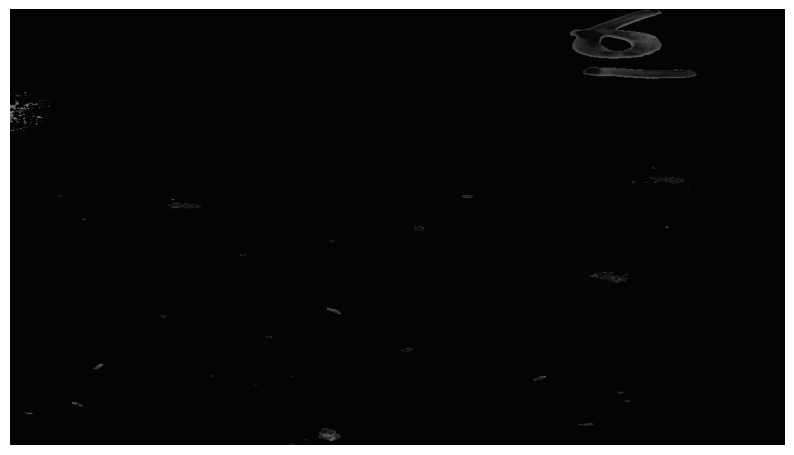

In [12]:
import matplotlib.pyplot as plt
import cv2

# If refined is still in OpenCV's BGR format, convert to RGB for matplotlib
refined_rgb = cv2.cvtColor(refined, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 8))
plt.imshow(refined_rgb)
plt.axis("off")   # hides the axes
plt.show()

In [13]:

# ----------------------------
# 3. Load YOLOv8 Model
# ----------------------------
model = YOLO("yolov8n.pt")  # lightweight model for testing
# You can swap for yolov8s.pt or yolov8m.pt for more accuracy

# ----------------------------
# 4. Run Detection
# ----------------------------
results = model.predict(refined, imgsz=640, conf=0.25)

# ----------------------------
# 5. Draw bounding boxes & labels
# ----------------------------
annotated = results[0].plot()  # built-in visualization

# Save output
cv2.imwrite("flies_detected.jpg", annotated)

print("✅ Detection complete! Results saved as flies_detected.jpg")


0: 384x640 (no detections), 76.9ms
Speed: 2.3ms preprocess, 76.9ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)
✅ Detection complete! Results saved as flies_detected.jpg


In [14]:
plt.show("flies_detected.jpg")